In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from astropy import units as u
import ccdproc as ccdp

from convenience_functions import show_image

In [8]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.

    Parameters
    ----------

    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.

    dark_exposure_times : list
        Exposure times for which there are darks.

    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.

    Returns
    -------

    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and
            np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):

        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, image.header['exptime']))


    return closest_dark_exposure

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

In [3]:
science_images_path = Path('2022_03_20', 'RV_UMa', 'Light', 'Luminance')
dark_images_path = Path('darks-reduced')
flats_path = Path('reduced-flats')

master_darks = ccdp.ImageFileCollection(dark_images_path)
master_flats = ccdp.ImageFileCollection(flats_path)
science_raw = ccdp.ImageFileCollection(science_images_path)

In [5]:
science_image_type = 'Light Frame'

combined_darks = {ccd.header['exptime']: ccd for ccd in master_darks.ccds(imagetyp='Dark Frame', combined=True)}
combined_flats = {ccd.header['filter']: ccd for ccd in master_flats.ccds(imagetyp='Flat Frame', combined=True)}

In [9]:
destination_path = Path('reduced-lights')
destination_path.mkdir( exist_ok = True)

In [ ]:
all_reds = []
light_ccds = []
for light, file_name in science_raw.ccds(imagetyp=science_image_type, return_fname=True, ccd_kwargs=dict(unit='adu')):
    light_ccds.append(light)

    closest_dark = find_nearest_dark_exposure(light, combined_darks.keys())
    reduced = ccdp.subtract_dark(light, combined_darks[closest_dark],
                                 exposure_time='exptime', exposure_unit=u.second
                                 )
    good_flat = combined_flats[reduced.header['filter']]
    reduced = ccdp.flat_correct(reduced, good_flat)
    all_reds.append(reduced)
    reduced.write(destination_path / file_name)

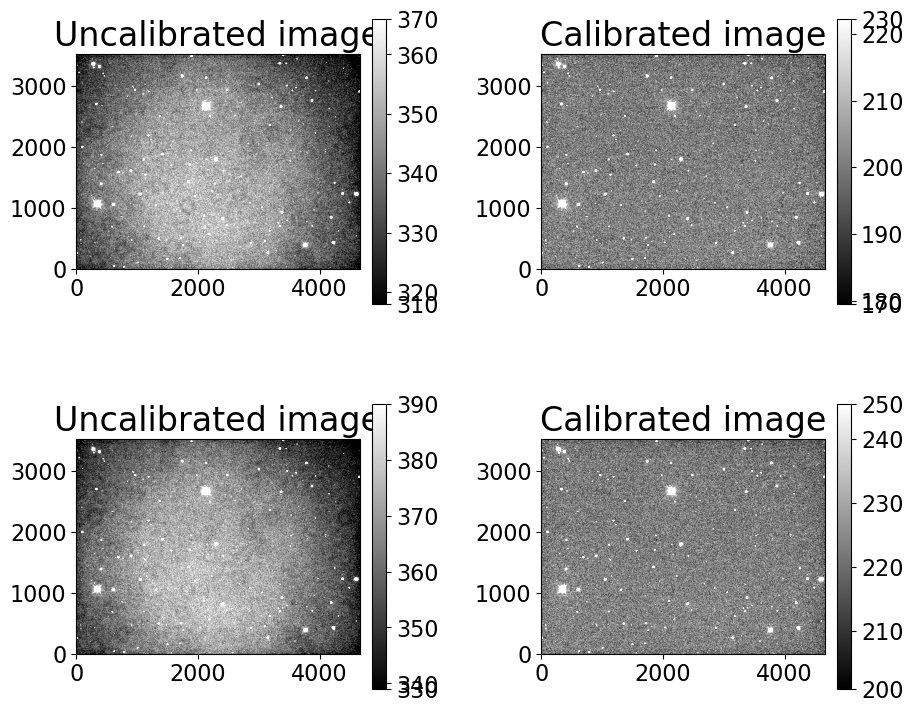

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

plt.subplots_adjust(wspace = 0.5, hspace = 0)
axes[0,0].set_title('Uncalibrated image')
show_image(light_ccds[0], cmap = 'gray', ax = axes[0,0], fig = fig, percl = 90)
axes[0,1].set_title('Calibrated image')
show_image(all_reds[0].data, cmap='gray', ax=axes[0, 1], fig=fig, percl=90)

axes[1,0].set_title('Uncalibrated image')
show_image(light_ccds[3], cmap = 'gray', ax = axes[1,0], fig = fig, percl = 90)
axes[1,1].set_title('Calibrated image')
show_image(all_reds[3], cmap = 'gray', ax = axes[1,1], fig = fig, percl = 90)

fig.savefig('Reduced_images.png')